# Lab 2: Reducing Data Movement using Data Reuse and Optimizing Memory Hierarchies

As you have seen in Lab 1, actual designs often fall below the roofline model.
In this lab, we will see that one reason designs fall below the roofline is because there is almost always more data movement than the theoretical minimum.
A key technique to reduce data movement and close the design-to-roofline gap is by leveraging data reuse.
In the following sections, we will learn about data reuse, how memory hierarchies and mappings together achieve data reuse, and how to optimize them.

To start, please fill in your biographical information and run the following cell to import packages we will use in this lab.

In [1]:
from loaders import *

from numbers import Number

import accelforge as af
from accelforge.mapper import Metrics
from accelforge.plotting.mappings import plot_energy_breakdown, plot_energy_comparison
from accelforge.plotting.roofline import plot_roofline
from loopnest import MemoryLevel, Tensor, get_actual_throughput

class AnswerMe:
    def __init__(self):
        raise RuntimeError("You missed a question!")

%matplotlib inline
import matplotlib.pyplot as plt

answer(
    question="0.0",
    subquestion=f"What is your name?",
    required_type=str,
    answer= 'Claude Agent',
)
answer(
    question="0.1",
    subquestion=f"What is your email address?",
    required_type=str,
    answer= 'claude@mit.edu',
)
answer(
    question="0.2",
    subquestion=f"What is your kerberos?",
    required_type=str,
    answer= 'claude',
)

0.0: What is your name?
	Claude Agent
0.1: What is your email address?
	claude@mit.edu
0.2: What is your kerberos?
	claude


## Section 1: Understanding Data Reuse and How to Achieve It

In this part, we will assume the following matrix multiplication workload.

$$
Z_{m,n} = A_{m,k} \times B_{k,n}
$$

We will analyze a very simple architecture in which an off-chip DRAM is connected directly to a MAC unit.

Please run the following cells that contain constants for this section.

In [2]:
# Rank shapes are as follows (DO NOT MODIFY):
M = 128
N = 64
K = 32

# Characteristics of the architecture
BANDWIDTH = 0.1   # 1 tensor-element/cycle DRAM bandwidth
THROUGHPUT = 1  # 1 op/cycle MAC unit

### Question 1: Analyzing Dataflows

We start with a loop nest. The order of loops, called the *dataflow*, determines the relative order of MAC operations.

The first dataflow we will analyze orders MAC operations such that (from outermost to innermost iterations):
1. at a highest level, we process entire rows (iterate over $m$),
2. within each row, we process one element of $Z$ at a time (iterate over $n$),
3. to process each element of $Z$, we accumulate the $A_{m,k} \times B_{k,n}$ product completely (iteration over $K$)

In other words, the dataflow is $Z$-stationary. However, describing dataflows this way is clunky. We will see this dataflow again more clearly as a Python code below.

Please read the description of the Python code below, read the following code cell, and compare the loop nest with the description of the dataflow above.
Then, run the code and read the printed access counts.

**Reading the Python code**

We will first use loop nests in Python to explore dataflows and dataplacements, to gain some intuition. Later, we will learn about the LoopTree notation for writing mappings, which is what we will use when using [AccelForge](https://accelergy-project.github.io/accelforge/).

In this Python code (see the next code block for example), the `MemoryLevel` class represents a memory level in the hierarchy. The `Tensor` class represents tensors. You can press `shift + tab` to bring up the docstrings for the constructors of each class.

All tensors (class `Tensor`) are allocated in DRAM using `with` statements. It is important to note that **tensor elements within a tile is accessed using local indices**, which means that the index used to access an element is relative to the tile not the original tensor. This is not relevant yet here because the DRAM stores the full tensor, but will be relevant (and pointed out again) later.

The loop nest iterates over the MAC operations in the matrix multiplication, and each MAC operates on the data in DRAM (*e.g.*, see `A_in_DRAM`).

Each access in tiles in the DRAM (*e.g.*, `A_in_DRAM[m,k]`) is tracked and can be printed using `DRAM.reads` and `DRAM.writes`. Similarly, capacity usage is tracked and can be printed using `DRAM.usage`.

In [3]:
DRAM = MemoryLevel("DRAM")

# Starting tensors
A = Tensor("A", shape=(M, K))
B = Tensor("B", shape=(K, N))
Z = Tensor("Z", shape=(M, N), is_output=True)

# A loop nest that performs Z = A x B

with DRAM.allocate(A) as A_in_DRAM:
    with DRAM.allocate(B) as B_in_DRAM:
        with DRAM.allocate(Z) as Z_in_DRAM:
            for m in range(M):
                for n in range(N):
                    for k in range(K):
                        Z_in_DRAM[m,n] += A_in_DRAM[m,k] * B_in_DRAM[k,n]

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))

DRAM reads by tensor: {'Z': 253952.0, 'A': 262144.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 262144}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}


Now, please answer the following questions.

In [4]:
answer(
    "1.1.1",
    "How many MAC operations were performed in the loop nest above?",
    answer= M*N*K,
    required_type=Number,
)

answer(
    "1.1.2",
    """
    True/False: multiple MAC operations use the same data (i.e., there is data
    reuse *opportunity*)?
    """,
    answer= True,
    required_type=bool,
)

answer(
    "1.1.3",
    "How many MAC operations require the same element of tensor A?",
    answer= N,
    required_type=Number,
)

answer(
    "1.1.4",
    """
    How many different elements of A are accessed before the same element of A
    is accessed again (referred to as the *reuse distance*)?
    In your counting, include the reused element of A.
    For example, if A[0,0] is accessed, then A[0,0] is accessed again, the count
    is 1. If A[0,0] is accessed, then A[0,1], then A[0,0] again, the count is 2.
    """,
    answer= K,
    required_type=Number,
)

1.1.1: How many MAC operations were performed in the loop nest above?
	262144
1.1.2: 
    True/False: multiple MAC operations use the same data (i.e., there is data
    reuse *opportunity*)?
    
	True
1.1.3: How many MAC operations require the same element of tensor A?
	64
1.1.4: 
    How many different elements of A are accessed before the same element of A
    is accessed again (referred to as the *reuse distance*)?
    In your counting, include the reused element of A.
    For example, if A[0,0] is accessed, then A[0,0] is accessed again, the count
    is 1. If A[0,0] is accessed, then A[0,1], then A[0,0] again, the count is 2.
    
	32


On-chip data *reuse* (not opportunity) occurs when multiple MAC operations that require the same data are supplied that data from an on-chip memory, thus avoiding data transfers from off-chip memory.

In this question, we will count data reuse as the number of times the a particular piece of data data is supplied from on-chip memory minus one (the first access is not reuse, only the subsequent ones are). For example, given the following hardware actions:
```
DRAM transfers a to on-chip memory
MAC reads a from on-chip memory (not reuse)
MAC reads a from on-chip memory (reuse)
MAC reads a from on-chip memory (reuse)
```
The data `a` is reused 2 times in on-chip memory.

Because our intent is to count how many times the on-chip memory eliminate DRAM transfers, the reuse is 4 times below.
```
DRAM transfers a to on-chip memory
MAC reads a from on-chip memory (not reuse)
MAC reads a from on-chip memory (reuse)
MAC reads a from on-chip memory (reuse)
DRAM transfers a to on-chip memory
MAC reads a from on-chip memory (not reuse)
MAC reads a from on-chip memory (reuse)
MAC reads a from on-chip memory (reuse)
```

Please answer the following questions.

In [5]:
answer(
    "1.1.5",
    "How many times is each element of tensor A reused on-chip?",
    answer= 0,
    required_type=Number,
)

answer(
    "1.1.6",
    """
    What is the minimum DRAM bandwidth (in tensor-element/cycle) required to
    avoid stalls (idle MAC units)?
    The bandwidth should include the sum of reads and writes.
    """,
    answer= (4*K - 1) / K,
    required_type=Number,
)

1.1.5: How many times is each element of tensor A reused on-chip?
	0
1.1.6: 
    What is the minimum DRAM bandwidth (in tensor-element/cycle) required to
    avoid stalls (idle MAC units)?
    The bandwidth should include the sum of reads and writes.
    
	3.96875


The following loop nest shows an `A`-stationary dataflow. Please run the cell.

In [6]:
### DO NOT MODIFY THIS BLOCK ###

DRAM = MemoryLevel("DRAM")

with DRAM.allocate(A) as A_in_DRAM:
    with DRAM.allocate(B) as B_in_DRAM:
        with DRAM.allocate(Z) as Z_in_DRAM:
            for m in range(M):
                for k in range(K):
                    for n in range(N):
                        Z_in_DRAM[m,n] += A_in_DRAM[m,k] * B_in_DRAM[k,n]

### END OF DO-NOT-MODIFY BLOCK ###

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))

DRAM reads by tensor: {'Z': 253952.0, 'A': 262144.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 262144}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}


Now, please answer the following questions.

In [7]:
answer(
    "1.1.7",
    "What is the reuse distance of A now?",
    answer= 1,
    required_type=Number,
)

answer(
    "1.1.8",
    """
    Did the number of DRAM accesses (both reads and writes) change for tensor
    A, B, and Z, respectively? Answer as a list of booleans.
    """,
    answer= [False, False, False],
    required_type=[bool, bool, bool],
)

1.1.7: What is the reuse distance of A now?
	1
1.1.8: 
    Did the number of DRAM accesses (both reads and writes) change for tensor
    A, B, and Z, respectively? Answer as a list of booleans.
    
	[False, False, False]


### Question 2: Dataflow over Partitioned Ranks

You may have noticed that the space of dataflow choices in the examples above is quite small.
There are $3! = 6$ possible permutations of loops.
Importantly, the limited dataflow space means there are only few choices for realizing different reuse distances.

For example, read the following dataflow again.

In [8]:
DRAM = MemoryLevel("DRAM")

# Starting tensors
A = Tensor("A", shape=(M, K))
B = Tensor("B", shape=(K, N))
Z = Tensor("Z", shape=(M, N), is_output=True)

# A loop nest that performs Z = A x B

with DRAM.allocate(A) as A_in_DRAM:
    with DRAM.allocate(B) as B_in_DRAM:
        with DRAM.allocate(Z) as Z_in_DRAM:
            for m in range(M):
                for n in range(N):
                    for k in range(K):
                        Z_in_DRAM[m,n] += A_in_DRAM[m,k] * B_in_DRAM[k,n]

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))

DRAM reads by tensor: {'Z': 253952.0, 'A': 262144.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 262144}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}


Please answer the following question.

In [9]:
answer(
    "1.2.1",
    """
    By varying the loop order, what are the different reuse distances we can get
    for tensor A?
    """,
    required_type=set[int],
    answer= {1, K, M, M*K},
)

answer(
    "1.2.2",
    """
    True/False: all subsequent uses of an element of A has the same reuse
    distance.
    """,
    required_type=bool,
    answer=True
)

1.2.1: 
    By varying the loop order, what are the different reuse distances we can get
    for tensor A?
    
	{32, 1, 4096, 128}
1.2.2: 
    True/False: all subsequent uses of an element of A has the same reuse
    distance.
    
	True


One way of expanding the space is by partitioning the ranks of the Einsum and creating loops over those partitioned ranks.

This concept is best demonstrated with an example. Please inspect and run the cell below.

In [10]:
# Create memory levels
DRAM = MemoryLevel("DRAM")

M1 = 4
M0 = M // M1
N1 = 4
N0 = N // N1
K1 = 4
K0 = K // K1

# A loop nest that performs Z = A x B
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m1 in range(M1):
        for n1 in range(N1):
            for k1 in range(K1):
                for m0 in range(M0):
                    for n0 in range(N0):
                        for k0 in range(K0):
                            m = M0*m1 + m0
                            k = K0*k1 + k0
                            n = N0*n1 + n0
                            Z_in_DRAM[m,n] += A_in_DRAM[m,k] * B_in_DRAM[k,n]

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))

DRAM reads by tensor: {'Z': 253952.0, 'A': 262144.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 262144}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}


Please answer the following questions.

In [11]:
answer(
    "1.2.3",
    """
    What are the reuse distances of tensor A, B, and Z, respectively?
    Each tensor may have multiple reuse distances.
    Please answer as a list of three items (one for each tensor in order), and
    each item is the set of reuse distances for that tensor.
    """,
    answer= [{K0, M0*K}, {K0*N0, K*N}, {1, M0*N0}],
    required_type=[set[Number], set[Number], set[Number]],
)

1.2.3: 
    What are the reuse distances of tensor A, B, and Z, respectively?
    Each tensor may have multiple reuse distances.
    Please answer as a list of three items (one for each tensor in order), and
    each item is the set of reuse distances for that tensor.
    
	[{8, 1024}, {128, 2048}, {512, 1}]


Using partitioning, we have a much finer control over reuse distances of each tensor.
In fact, we can now determine reuse distances by permuting loops and by determining the shape of our partitioning (values of `M0`, `N0`, `K0`, `M1`, etc.).

### Question 3: Analysis Using the Roofline Model

Now, let's use the roofline model to analyze the workload.

**Note:** there are two equivalent terminologies: computational and operational intensity. These terms mean the same thing.

Please answer the following questions.

In [12]:
# Please set this variable to the computational intensity of the workload.
# Please set it carefully, this variable will be used in future code blocks!
computational_intensity = M*N*K / (M*K + K*N + M*N)
########################
#### YOUR CODE HERE ####
########################
print("Computational Intensity:", computational_intensity)

answer(
    "1.3.1",
    "True/False: Computational intensity assumes no data reuse.",
    answer= False,
    required_type=bool,
)

answer(
    "1.3.2",
    "True/False: Computational intensity assumes maximum data reuse.",
    answer= True,
    required_type=bool,
)

answer(
    "1.3.3",
    """What is the computational intensity of the matrix multiplication above
    given the rank shapes?
    """,
    answer=computational_intensity,
    required_type=Number,
)

answer(
    "1.3.4",
    """
    Still assuming one MAC unit, what is the minimum DRAM bandwidth (in GB/s)
    required to avoid stalls?
    """,
    answer= (M*K + K*N + M*N) / (M*N*K),
    required_type=Number,
)

Computational Intensity: 18.285714285714285
1.3.1: True/False: Computational intensity assumes no data reuse.
	False
1.3.2: True/False: Computational intensity assumes maximum data reuse.
	True
1.3.3: What is the computational intensity of the matrix multiplication above
    given the rank shapes?
    
	18.285714285714285
1.3.4: 
    Still assuming one MAC unit, what is the minimum DRAM bandwidth (in GB/s)
    required to avoid stalls?
    
	0.0546875


We will now compare the computational throughput achieved using the mapping we provided above (copied below) with the roofline model.

For fun, based on your answers above, try to determine whether the actual throughput will be at, near, or far from the roofline.

Please run the following cell.

DRAM reads by tensor: {'Z': 253952.0, 'A': 262144.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 262144}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}


Text(18.285714285714285, 0.025196850393700787, ' Dataflow Only')

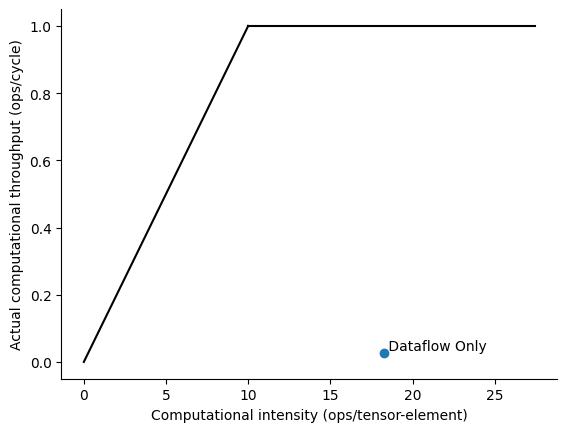

In [13]:
# Rank shapes are as follows (DO NOT MODIFY):
M = 128
N = 64
K = 32

DRAM = MemoryLevel("DRAM")

# Starting tensors
A = Tensor("A", shape=(M, K))
B = Tensor("B", shape=(K, N))
Z = Tensor("Z", shape=(M, N), is_output=True)

# A loop nest that performs Z = A x B

with DRAM.allocate(A) as A_in_DRAM:
    with DRAM.allocate(B) as B_in_DRAM:
        with DRAM.allocate(Z) as Z_in_DRAM:
            for m in range(M):
                for n in range(N):
                    for k in range(K):
                        Z_in_DRAM[m,n] += A_in_DRAM[m,k] * B_in_DRAM[k,n]

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))

dataflow_only_throughput = get_actual_throughput(BANDWIDTH, THROUGHPUT, DRAM, M*N*K)

fig, ax = plot_roofline(
    BANDWIDTH,
    THROUGHPUT,
    max_computational_intensity=computational_intensity*1.5
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")
ax.scatter(computational_intensity, dataflow_only_throughput)
ax.text(computational_intensity, dataflow_only_throughput, " Dataflow Only", va="bottom", ha="left")

### Question 4: Leveraging Data Reuse Using Dataplacement

Dataflow alone does not result in data reuse, it determines the order of operations and thus only the access pattern of tensor elements. To achieve reuse, tensor elements must be kept in a buffer and accessed several times.

We will achieve reuse by inserting a global buffer (GLB) between DRAM and MAC units.

*Dataplacement* is the specification of which tensor tiles are kept in each memory level. In the previous loopnest, we have a very simple dataplacement that only says that the DRAM holds every tensor. Now, we will include the dataplacement for the GLB.

Please run the following code cell.

In [14]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

# A loop nest that performs Z = A x B
# Note: we collapse the DRAM allocations into one with-statement to avoid too many nested levels for clarity
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m in range(M):
        with GLB.allocate(A_in_DRAM[m, :]) as A_in_GLB:
            for n in range(N):
                with GLB.allocate(Z_in_DRAM[m, n]) as Z_in_GLB:
                    for k in range(K):
                        with GLB.allocate(B_in_DRAM[k, n]) as B_in_GLB:
                            Z_in_GLB[0,0] += A_in_GLB[0,k] * B_in_GLB[0,0]

dataplacement_DRAM_throughput = get_actual_throughput(BANDWIDTH, THROUGHPUT, DRAM, M*N*K)

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))
print()
print("GLB reads by tensor:", dict(GLB.reads))
print("GLB writes by tensor:", dict(GLB.writes))
print("GLB capacity usage by tensor:", dict(GLB.usage))

DRAM reads by tensor: {'A': 4096.0, 'Z': 0.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 8192.0}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}

GLB reads by tensor: {'Z': 262144.0, 'A': 262144.0, 'B': 262144.0}
GLB writes by tensor: {'A': 4096.0, 'Z': 262144.0, 'B': 262144.0}
GLB capacity usage by tensor: {'A': 32, 'Z': 1, 'B': 1}


Please note the index of `A_in_GLB`, `B_in_GLB`, and `Z_in_GLB`.
The indexing is **local**, which means that:
- in the line `with GLB.allocate(A_in_DRAM[m, :])`, a tile with shape 1 by K is allocated in the GLB,
- in the line `Z_in_GLB[0,0] += A_in_GLB[0,k] * B_in_GLB[0,0]`, the indexing `A_in_GLB[0,k]` is to get the element `(0, k)` in that tile in GLB, which is the same element as `A_in_DRAM[m,k]`.

Please answer the following questions.

In [15]:
answer(
    "1.4.1",
    """
    True/False: There is reuse of A, B, Z in GLB. Answer as a list of three
    booleans, one for each tensor respectively.
    """,
    answer= [True, False, True],
    required_type=[bool, bool, bool],
)

answer(
    "1.4.2",
    """
    Which loop(s) out of m, n, k contribute to reuse of tensors A, B, and Z in GLB?
    Answer as a list (one element for each tensor respectively) of a set of loop
    variable names.  If no loops contribute to reuse for a tensor, use the empty
    set for that tensor.
    """,
    answer= [{"n"}, set(), {"k"}],
    required_type=[set[str], set[str], set[str]],
)

answer(
    "1.4.3",
    """
    What is the minimum DRAM bandwidth (in tensor-elements/cycle) required
    to avoid stalls?
    """,
    answer= (M*K + M*N*K + M*N) / (M*N*K),
    required_type=Number,
)

answer(
    "1.4.4",
    """
    True/False: by modifying the loop nest, data reuse can be achieved using
    capacity less than the reuse distance.
    """,
    answer= True,
    required_type=bool,
)

1.4.1: 
    True/False: There is reuse of A, B, Z in GLB. Answer as a list of three
    booleans, one for each tensor respectively.
    
	[True, False, True]
1.4.2: 
    Which loop(s) out of m, n, k contribute to reuse of tensors A, B, and Z in GLB?
    Answer as a list (one element for each tensor respectively) of a set of loop
    variable names.  If no loops contribute to reuse for a tensor, use the empty
    set for that tensor.
    
	[{'n'}, set(), {'k'}]
1.4.3: 
    What is the minimum DRAM bandwidth (in tensor-elements/cycle) required
    to avoid stalls?
    
	1.046875
1.4.4: 
    True/False: by modifying the loop nest, data reuse can be achieved using
    capacity less than the reuse distance.
    
	True


**Look closely at the access counts of the GLB (copied in cell below)!** How come there are writes for $A$ and $B$, which are not output tensors? These writes are because tensor elements are moved *into* the GLB (causing writes) to be used by the MAC (which only reads).

In [16]:
print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))
print()
print("GLB reads by tensor:", dict(GLB.reads))
print("GLB writes by tensor:", dict(GLB.writes))
print("GLB capacity usage by tensor:", dict(GLB.usage))

DRAM reads by tensor: {'A': 4096.0, 'Z': 0.0, 'B': 262144.0}
DRAM writes by tensor: {'Z': 8192.0}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}

GLB reads by tensor: {'Z': 262144.0, 'A': 262144.0, 'B': 262144.0}
GLB writes by tensor: {'A': 4096.0, 'Z': 262144.0, 'B': 262144.0}
GLB capacity usage by tensor: {'A': 32, 'Z': 1, 'B': 1}


For the output tensor, $Z$, there are two origins of writes to the GLB: DRAM and MAC.
Elements of $Z$ are written into the GLB from the DRAM to be read by the MAC (similarly to $A$ and $B$), but the MAC will also write its result back to the GLB.
However, we note one optimization: The very first use of a Z value does not need a read from the DRAM nor a write to the GLB because we know the initial value is zero!
For example, see number of reads of $Z$ from the DRAM.

Moreover, the GLB is also read for two reasons: to provide a partial sum to the MAC and to send the result back to the DRAM.

Please answer the following question.

In [17]:
answer(
    "1.4.5",
    """
    How many of tensor Z writes in the GLB are due from DRAM and how many are
    from MAC, respectively? Answer as a list of numbers.
    """,
    required_type=[Number, Number],
    answer= [0, M*N*K],
)

1.4.5: 
    How many of tensor Z writes in the GLB are due from DRAM and how many are
    from MAC, respectively? Answer as a list of numbers.
    
	[0, 262144]


We should note an important fact: the amount of GLB capacity used to reuse a tensor is related to the reuse distance.

Please answer the following question.

In [18]:
answer(
    "1.4.6",
    "What are the reuse distances of tensor A, B, and Z? Answer as a list.",
    answer= [K, N*K, 1],
    required_type=[Number, Number, Number],
)

answer(
    "1.4.7",
    """
    Changing only the dataplacement (i.e., without changing the loop nest),
    is it possible to reuse tensor B while using less capacity than the reuse
    distance of B?
    """,
    required_type=bool,
    answer= True,
)

1.4.6: What are the reuse distances of tensor A, B, and Z? Answer as a list.
	[32, 2048, 1]


1.4.7: 
    Changing only the dataplacement (i.e., without changing the loop nest),
    is it possible to reuse tensor B while using less capacity than the reuse
    distance of B?
    
	True


Now that we are achieving data reuse, let's see how we fare in comparison to the mapping with only dataflow and the roofline. Please run the following cell.

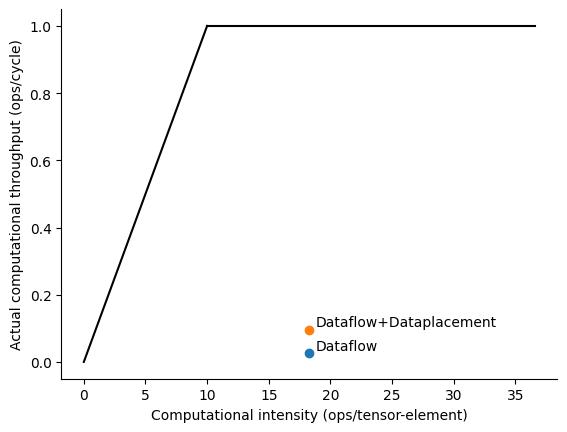

In [19]:
fig, ax = plot_roofline(
    BANDWIDTH,
    THROUGHPUT,
    max_computational_intensity=computational_intensity*2
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")

for throughput, label in [
    (dataflow_only_throughput, "Dataflow"),
    (dataplacement_DRAM_throughput, "Dataflow+Dataplacement"),
]:
    ax.scatter(computational_intensity, throughput)
    ax.text(computational_intensity*1.03, throughput*1.01, label, va="bottom", ha="left")

Better! But we are still leaving a wide gap, which should be expected given your answer to question 1.4.1.
We will try to do better in Section 2.
For now, remember that this additional throughput is not without a cost: we now have to devote precious chip area to the GLB!

Finally, see what happens when we partition ranks. Please run the cell below.

In [20]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

M1 = 4
M0 = M // M1
N1 = 4
N0 = N // N1
K1 = 4
K0 = K // K1

# A loop nest that performs Z = A x B
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m1 in range(M1):
        for n1 in range(N1):
            with GLB.allocate(Z_in_DRAM[M0*m1:M0*(m1+1), N0*n1:N0*(n1+1)]) as Z_in_GLB:
                for k1 in range(K1):
                    with GLB.allocate(B_in_DRAM[K0*k1:K0*(k1+1), N0*n1:N0*(n1+1)]) as B_in_GLB:
                        for m0 in range(M0):
                            with GLB.allocate(A_in_DRAM[M0*m1+m0, K0*k1:K0*(k1+1)]) as A_in_GLB:
                                for n0 in range(N0):
                                    for k0 in range(K0):
                                        Z_in_GLB[m0,n0] += A_in_GLB[0,k0] * B_in_GLB[k0,n0]

tiled_dataplacement_throughput = get_actual_throughput(BANDWIDTH, THROUGHPUT, DRAM, M*N*K)

print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("DRAM capacity usage by tensor:", dict(DRAM.usage))
print()
print("GLB reads by tensor:", dict(GLB.reads))
print("GLB writes by tensor:", dict(GLB.writes))
print("GLB capacity usage by tensor:", dict(GLB.usage))

DRAM reads by tensor: {'Z': 0.0, 'B': 8192.0, 'A': 16384.0}
DRAM writes by tensor: {'Z': 8192.0}
DRAM capacity usage by tensor: {'A': 4096, 'B': 2048, 'Z': 8192}

GLB reads by tensor: {'Z': 262144.0, 'A': 262144.0, 'B': 262144.0}
GLB writes by tensor: {'Z': 262144.0, 'B': 8192.0, 'A': 16384.0}
GLB capacity usage by tensor: {'Z': 512, 'B': 128, 'A': 8}


Please answer the following questions.

In [21]:
answer(
    "1.4.8",
    """
    Which loop(s) out of m1, n1, k1, m0, n0, k0 contribute to reuse of tensors
    A, B, and Z in GLB?
    Answer as a list (one element for each tensor respectively) of a set of loop
    variable names. If no loops contribute to reuse for a tensor, use the empty
    set for that tensor.
    """,
    answer= [{"n0"}, {"m0"}, {"k0", "k1"}],
    required_type=[set[str], set[str], set[str]],
)

answer(
    "1.4.9",
    """
    True/False: We now have more variables we can tune to control the trade-off
    between GLB capacity usage and the amount of data reuse compared to before
    partitioning.
    """,
    required_type=bool,
    answer= True,
)

1.4.8: 
    Which loop(s) out of m1, n1, k1, m0, n0, k0 contribute to reuse of tensors
    A, B, and Z in GLB?
    Answer as a list (one element for each tensor respectively) of a set of loop
    variable names. If no loops contribute to reuse for a tensor, use the empty
    set for that tensor.
    
	[{'n0'}, {'m0'}, {'k1', 'k0'}]
1.4.9: 
    True/False: We now have more variables we can tune to control the trade-off
    between GLB capacity usage and the amount of data reuse compared to before
    partitioning.
    
	True


## Section 2: Optimizing Mappings for Data Reuse

Now what we learned about how combining dataflow and dataplacement results in data reuse,
and that data reuse comes at a cost of using GLB capacity,
we will learn how to optimize dataplacement and dataflow to achieve the best trade-off.

### Question 1: Optimizing Dataplacement Given Dataflow



Please modify the dataplacement and tile shapes of the following mapping (in the cell below) such that the fewest possible DRAM accesses is achieved (maximum data reuse) while minimizing GLB capacity usage.
Specifically, you should:
- move the `with` statements around the loops (keeping the loop order the same),
- update the tile shape (the bounds of index within the brackets),
- update the index of the computation statement (the innermost body of the loop).

Because updating the shape and the index is quite tedious, you might find a brute-force search unproductive.
Instead, try two or three choices, write down these choices, and analyze them to arrive at the solution, which you implement once.

In [22]:
### DO NOT MODIFY THIS BLOCK ###

# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

### END OF DO-NOT-MODIFY BLOCK ###


# Modify the following by reordering with-statements for the GLB and determining tile shapes only
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    with GLB.allocate(B_in_DRAM[:, :]) as B_in_GLB:
        for m in range(M):
            with GLB.allocate(A_in_DRAM[m, :]) as A_in_GLB:
                for n in range(N):
                    with GLB.allocate(Z_in_DRAM[m, n]) as Z_in_GLB:
                        for k in range(K):
                            Z_in_GLB[0,0] += A_in_GLB[0,k] * B_in_GLB[k,n]
########################
#### YOUR CODE HERE ####
########################


### DO NOT MODIFY THIS BLOCK ###

total_DRAM_accesses = sum(DRAM.reads.values()) + sum(DRAM.writes.values())
print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("Total DRAM accesses:", total_DRAM_accesses)
print()
print("GLB reads by tensor:", dict(GLB.reads))
print("GLB writes by tensor:", dict(GLB.writes))
print("GLB capacity usage by tensor:", dict(GLB.usage))
print("Total GLB usage: ", sum(GLB.usage.values()))

optimized_throughput = get_actual_throughput(BANDWIDTH, THROUGHPUT, DRAM, M*N*K)

answer(
    "2.1.1",
    "Minimum DRAM accesses is achieved.",
    answer=total_DRAM_accesses == M*N + M*K + K*N,
    required_type=bool
)

answer(
    "2.1.2",
    "Smallest GLB usage is achieved.",
    answer=sum(GLB.usage.values()) == K*N + K + 1,
    required_type=bool
)

### END OF DO-NOT-MODIFY BLOCK ###

DRAM reads by tensor: {'B': 2048.0, 'A': 4096.0, 'Z': 0.0}
DRAM writes by tensor: {'Z': 8192.0}
Total DRAM accesses: 14336.0

GLB reads by tensor: {'Z': 262144.0, 'A': 262144.0, 'B': 262144.0}
GLB writes by tensor: {'B': 2048.0, 'A': 4096.0, 'Z': 262144.0}
GLB capacity usage by tensor: {'B': 2048, 'A': 32, 'Z': 1}
Total GLB usage:  2081
2.1.1: Minimum DRAM accesses is achieved.
	True
2.1.2: Smallest GLB usage is achieved.
	True


Now, we will compare this mapping with the previous ones and the roofline. Please run the cell below.

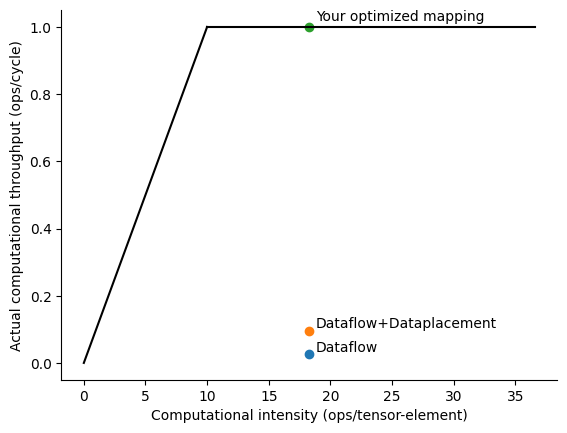

In [23]:
fig, ax = plot_roofline(
    BANDWIDTH,
    THROUGHPUT,
    max_computational_intensity=computational_intensity*2
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")

for throughput, label in [
    (dataflow_only_throughput, "Dataflow"),
    (dataplacement_DRAM_throughput, "Dataflow+Dataplacement"),
    (optimized_throughput, "Your optimized mapping")
]:
    ax.scatter(computational_intensity, throughput)
    ax.text(computational_intensity*1.03, throughput*1.01, label, va="bottom", ha="left")

### Question 2: Optimizing Dataflow Given Dataplacement

Please modify the dataflow and tile shapes of the following mapping (*i.e.*, only reorder loop orders and update the tile shapes) such that the fewest possible DRAM accesses is achieved (maximum data reuse) while minimizing GLB capacity usage.

Specifically, you should:
- move the loop statements around the `with` statements (the order of `with` statements the same),
- update the tile shape (the bounds of index within the brackets),
- update the index of the computation statement (the innermost body of the loop).

Because updating the shape and the index is quite tedious, you might find a brute-force search unproductive.
Instead, try two or three choices, write down these choices, and analyze the amount of reuse to arrive at the solution, which you implement once.

In [24]:
### DO NOT MODIFY THIS BLOCK ###

# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

### END OF DO-NOT-MODIFY BLOCK ###


# Modify the following by reordering for-statements and determining tile shapes only
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    with GLB.allocate(A_in_DRAM[:, :]) as A_in_GLB:
        for n in range(N):
            with GLB.allocate(B_in_DRAM[:, n]) as B_in_GLB:
                for m in range(M):
                    with GLB.allocate(Z_in_DRAM[m, n]) as Z_in_GLB:
                        for k in range(K):
                            Z_in_GLB[0,0] += A_in_GLB[m,k] * B_in_GLB[k,0]
########################
#### YOUR CODE HERE ####
########################

### DO NOT MODIFY THIS BLOCK ###


total_DRAM_accesses = sum(DRAM.reads.values()) + sum(DRAM.writes.values())
print("DRAM reads by tensor:", dict(DRAM.reads))
print("DRAM writes by tensor:", dict(DRAM.writes))
print("Total DRAM accesses:", total_DRAM_accesses)
print()
print("GLB reads by tensor:", dict(GLB.reads))
print("GLB writes by tensor:", dict(GLB.writes))
print("GLB capacity usage by tensor:", dict(GLB.usage))
print("Total GLB usage: ", sum(GLB.usage.values()))

answer(
    "2.2.1",
    "Minimum DRAM accesses is achieved.",
    answer=total_DRAM_accesses == M*N + M*K + K*N,
    required_type=bool
)

answer(
    "2.2.2",
    "Smallest GLB usage is achieved.",
    answer=sum(GLB.usage.values()) == M*K + K + 1,
    required_type=bool
)

### END OF DO-NOT-MODIFY BLOCK ###

DRAM reads by tensor: {'A': 4096.0, 'B': 2048.0, 'Z': 0.0}
DRAM writes by tensor: {'Z': 8192.0}
Total DRAM accesses: 14336.0

GLB reads by tensor: {'Z': 262144.0, 'A': 262144.0, 'B': 262144.0}
GLB writes by tensor: {'A': 4096.0, 'B': 2048.0, 'Z': 262144.0}
GLB capacity usage by tensor: {'A': 4096, 'B': 32, 'Z': 1}
Total GLB usage:  4129
2.2.1: Minimum DRAM accesses is achieved.
	True
2.2.2: Smallest GLB usage is achieved.
	True


Having done these exercises, you can imagine how large the space of mappings (called a *mapspace*) if we include rank partitioning.
Can you imagine optimizing these mappings completely by hand?
Instead, we will learn about the LoopTree mapping notation, which makes reading and writing mappings easier, and the [AccelForge](https://accelergy-project.github.io/accelforge/) mapper, which will automatically search for an optimal mapping.

### Question 3: Understanding LoopTree Mappings

Now, we will learn how to write mappings in the LoopTree notation.

For now, a LoopTree mapping has three node types:
- a loop node
- a storage node
- a compute node

The mapping we have been writing in Python can easily be written in the LoopTree notation.


First, we need to see the workload. Please run the cell below.

In [25]:
with open("workload/matmul.yaml", "r") as f:
    print(f.read())

workload:
  # version: "0.5"
  rank_sizes:
    M: {{ M }}
    N: {{ N }}
    K: {{ K }}

  einsums:
  - name: matmul
    tensor_accesses:
    - {name: A, projection: [m, k], bits_per_value: 8}
    - {name: B, projection: [k, n], bits_per_value: 8}
    - {name: Z, projection: [m, n], output: True, bits_per_value: 8}


This workload is just a matrix multiplication.
We'll note for now that the Einsum is named `matmul`.

Please inspect the mapping in Python below, and the printed equivalent LoopTree mapping in YAML.

In [26]:
# For example, this mapping is equivalent to the LoopTree below

# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m in range(M):
        for n in range(N):
            with GLB.allocate(Z_in_DRAM[m, n]) as Z_in_GLB:
                for k in range(K):
                    with GLB.allocate(A_in_DRAM[m, k]) as A_in_GLB:
                        with GLB.allocate(B_in_DRAM[k, n]) as B_in_GLB:
                            Z_in_GLB[0,0] += A_in_GLB[0,0] * B_in_GLB[0,0]


with open("mapping/simple.yaml", "r") as f:
    print(f.read())

mapping:
  nodes:
  - !Storage
    component: DRAM
    tensors: [A, B, Z]
  - !Temporal
    rank_variable: m
    tile_shape: 1
  - !Temporal
    rank_variable: n
    tile_shape: 1
  - !Storage
    component: GLB
    tensors: [Z]
  - !Temporal
    rank_variable: k
    tile_shape: 1
  - !Storage
    component: GLB
    tensors: [A]
  - !Storage
    component: GLB
    tensors: [B]
  - !Compute
    component: MAC
    einsum: matmul


In the LoopTree notation, the `!Temporal` nodes are equivalent to the loops in Python.
They are *temporal* loop nodes, which represent iterations in time.
We'll learn about *spatial* loop nodes in Lab 3. In the LoopTree notation, the `tile_shape` is the shape of the partition of the rank.
For example, a loop `for m in range(M)` can be interpreted as iterating over `M` partitions, each with shape 1.
This concept will become clearer in later examples.

Note how the `!Storage` nodes are equivalent to the `with` statements that we used to represent dataplacement choice,
but more convenient since we do not have to explicitly write the tile shape.
In the LoopTree notation, tile shapes are inferred to be the smallest tile shape possible to achieve reuse over loops underneath the storage nodes.

Finally, the `!Compute` node represents processing an operation from the Einsum named `matmul`, which is a multiply-and-accumulate operation, using the architecture component named `MAC` (which we'll assume exists).

Once the YAML is parsed into AccelForge, we can render it. Please run the cell below.

In [27]:
af.Spec.from_yaml("mapping/simple.yaml").mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'Z'], component='DRAM', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='n', tile_shape=1, initial_tile_shape=None), Storage(tensors=['Z'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='k', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Compute(einsum='matmul', component='MAC', component_object=None)])

Now, please read the loop nest below and write the equivalent LoopTree mapping in the YAML file `mapping/your_mapping.yaml`.

In [28]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m in range(M):
        with GLB.allocate(Z_in_DRAM[m, n]) as Z_in_GLB:
            for k in range(K):
                with GLB.allocate(A_in_DRAM[m, k]) as A_in_GLB:
                    for n in range(N):
                        with GLB.allocate(B_in_DRAM[k, n]) as B_in_GLB:
                            Z_in_GLB[0,0] += A_in_GLB[0,0] * B_in_GLB[0,0]

The following cell visualizes your mapping.

In [29]:
spec = af.Spec.from_yaml(
    "mapping/your_mapping.yaml",
)
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'Z'], component='DRAM', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['Z'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='k', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='n', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Compute(einsum='matmul', component='MAC', component_object=None)])

Based on the LoopTree mapping above, please answer the following questions.

In [30]:
answer(
    "2.3.1",
    "What tensors are kept in the GLB?",
    required_type=set[str],
    answer= {"A", "B", "Z"},
)

answer(
    "2.3.2",
    """
    Which loops reuse elements of Z in the GLB? Write as a set of rank variables
    """,
    required_type=set[str],
    answer= {"k"},
)

2.3.1: What tensors are kept in the GLB?
	{'B', 'A', 'Z'}
2.3.2: 
    Which loops reuse elements of Z in the GLB? Write as a set of rank variables
    
	{'k'}


Now, we will look at a LoopTree mapping with partitioned ranks.

For convenience, when there ranks are partitioned, and there are multiple loops over the rank, no indices need to be added to the rank variables in the LoopTree notation.

Please run the following cell.

In [31]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

M1 = 4
M0 = M // M1
N1 = 4
N0 = N // N1
K1 = 4
K0 = K // K1

# A loop nest that performs Z = A x B
with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m1 in range(M1):
        for n1 in range(N1):
            for k1 in range(K1):
                with GLB.allocate(Z_in_DRAM[M0*m1:M0*(m1+1), N0*n1:N0*(n1+1)]) as Z_in_GLB:
                    with GLB.allocate(A_in_DRAM[M0*m1:M0*(m1+1), K0*k1:K0*(k1+1)]) as A_in_GLB:
                        with GLB.allocate(B_in_DRAM[K0*k1:K0*(k1+1), N0*n1:N0*(n1+1)]) as B_in_GLB:
                            for m0 in range(M0):
                                for n0 in range(N0):
                                    for k0 in range(K0):
                                        Z_in_GLB[m0,n0] += A_in_GLB[m0,k0] * B_in_GLB[k0,n0]


with open("mapping/partitioned.yaml", "r") as f:
    print(f.read())

mapping:
  nodes:
  - !Storage
    component: DRAM
    tensors: [A, B, Z]
  - !Temporal
    rank_variable: m
    tile_shape: {{M0}}
  - !Temporal
    rank_variable: n
    tile_shape: {{N0}}
  - !Temporal
    rank_variable: k
    tile_shape: {{K0}}
  - !Storage
    component: GLB
    tensors: [Z]
  - !Storage
    component: GLB
    tensors: [A]
  - !Storage
    component: GLB
    tensors: [B]
  - !Temporal
    rank_variable: m
    tile_shape: 1
  - !Temporal
    rank_variable: n
    tile_shape: 1
  - !Temporal
    rank_variable: k
    tile_shape: 1
  - !Compute
    component: MAC
    einsum: matmul


The double curly-braces you see (*e.g.*, `{{M0}}`) are values that will be substituted when we parse these YAML files into Python.
We will do the substitution such that they take on the same value as the Python variable (*e.g.*, `{{M0}}` will be replaced with the numerical value of `M0` in the code above).

Note the tile shapes of the upper temporal loops over `m`, `n`, and `k`.
In the Python loops, the iteration `for m1 in range(M1)` implies an iteration over `M1` partitions, each with shape `M0`.
In LoopTree, we specify the shape `M0` instead of the number of iterations `M1`.

Please run the cell below to see the rendered version of the parsed LoopTree.

In [32]:
af.Spec.from_yaml("mapping/partitioned.yaml", jinja_parse_data={"M0": M0, "N0": N0, "K0": K0}).mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'Z'], component='DRAM', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=32, initial_tile_shape=None), Temporal(rank_variable='n', tile_shape=16, initial_tile_shape=None), Temporal(rank_variable='k', tile_shape=8, initial_tile_shape=None), Storage(tensors=['Z'], component='GLB', component_object=None, persistent=False), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='n', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='k', tile_shape=1, initial_tile_shape=None), Compute(einsum='matmul', component='MAC', component_object=None)])

### Question 4: Optimizing Mappings Automatically using a Mapper

Commonly, a mapping is not optimized by hand, but using a *mapper* that optimizes the mapping for a given architecture and workload. In this question, we will learn how to use the [AccelForge](https://accelergy-project.github.io/accelforge/) mapper.

First, we must specify an architecture.
A configurable architecture specification has been written for you.

The following architecture is set to have
- DRAM bandwidth of 3 GB/s (the specification is in b/s)
- GLB bandwidth of 3 GB/s (the specification is in b/s)

Remember that lowercase b means bits and uppercase B means bytes (8 bits).

Importantly, we'll set the GLB capacity to be quite small:
- GLB capacity is 8 B (the specification is in b)

We will also specify a workload, which we will discuss later.

Please run the following cell. You can inspect the output, which visualizes the architecture.

In [33]:
spec = af.Spec.from_yaml(
    "arch/simple_scalar.yaml",
    "workload/matmul.yaml",
    jinja_parse_data=dict(M=M, N=N, K=K, DRAM_BW=8*3e9, GLB_BW=8*3e9, GLB_CAPACITY=8*8)
)
spec.arch

FileNotFoundError: [Errno 2] "dot" not found in path.

Arch(nodes=ArchNodes([Memory(name='DRAM', spatial=[], component_class=None, component_model=None, component_modeling_log=[], actions=[TensorHolderAction(name='read', energy=7.03e-12, energy_scale=1, latency=1e-09, latency_scale=1, extra_attributes_for_component_model=EvalExtras(), bits_per_action='1 if bits_per_action is None else bits_per_action'), TensorHolderAction(name='write', energy=7.03e-12, energy_scale=1, latency=1e-09, latency_scale=1, extra_attributes_for_component_model=EvalExtras(), bits_per_action='1 if bits_per_action is None else bits_per_action')], enabled=True, area=0, total_area=None, area_scale=1, leak_power=0, total_leak_power=None, leak_power_scale=1, energy_scale=1, total_latency='(read_actions + write_actions) / (24000000000.0)', latency_scale=1, n_parallel_instances=1, extra_attributes_for_component_model=_ExtraAttrs(), tensors=Tensors(keep='~Intermediates', may_keep='All', back='Nothing', tile_shape=[], no_refetch_from_above='~All', tensor_order_options=[], fo

The workload is a matrix multiplication. The following cell visualizes the workload, please run it.

In [34]:
spec.workload

FileNotFoundError: [Errno 2] "dot" not found in path.

Workload(einsums=[Einsum(name='matmul', tensor_accesses=[TensorAccess(name='A', projection={'M': 'm', 'K': 'k'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='B', projection={'K': 'k', 'N': 'n'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='Z', projection={'M': 'm', 'N': 'n'}, output=True, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8)], iteration_space_shape=[], rank_sizes={}, is_copy_operation=False, renames=[], n_instances=1)], iteration_space_shape={}, rank_sizes={'M': 128, 'N': 64, 'K': 32}, n_instances=1, bits_per_value={}, persistent_tensors=None)

Now, we run the mapper. Please run the following cell.

In [35]:
mappings = spec.map_workload_to_arch()
mappings

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 1it [00:00,  4.96it/s]

Generating pmapping templates for compute MAC Einsum matmul: 16it [00:00, 64.09it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

Einsum matmul has 16 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  MAC computes matmul
	1	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  MAC computes matmul
	2	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  MAC computes matmul
	3	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  MAC computes matmul
	4	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  [B in GLB] T-m  MAC computes matmul
	5	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  [A in GLB] T-n  MAC computes matmul
	6	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  [Z in GLB] T-k  MAC computes matmul
	7	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  [A in GLB] T-n  MAC computes matmul
	8	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  [Z in GLB] T-k  MAC computes matmul
	9	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  [B in GLB] T-m  MAC computes matmul
	10	[Z in DRAM] [B in DR

Generating pmappings:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pmappings:   6%|▋         | 1/16 [00:02<00:39,  2.62s/it]

Generating pmappings:  12%|█▎        | 2/16 [00:02<00:16,  1.17s/it]

Generating pmappings:  19%|█▉        | 3/16 [00:03<00:10,  1.24it/s]

Generating pmappings:  25%|██▌       | 4/16 [00:03<00:08,  1.44it/s]

Generating pmappings:  31%|███▏      | 5/16 [00:05<00:11,  1.06s/it]

Generating pmappings:  44%|████▍     | 7/16 [00:05<00:05,  1.54it/s]

Generating pmappings:  50%|█████     | 8/16 [00:06<00:05,  1.44it/s]

Generating pmappings:  69%|██████▉   | 11/16 [00:06<00:01,  2.89it/s]

Generating pmappings:  81%|████████▏ | 13/16 [00:07<00:00,  3.49it/s]

Generating pmappings:  94%|█████████▍| 15/16 [00:07<00:00,  4.58it/s]

Generating pmappings: 100%|██████████| 16/16 [00:07<00:00,  5.08it/s]

Generating pmappings: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]

Grouping pmappings for matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]

matmul: 338 total, 52 (1/6) valid, 48 (1/7) evaluated, 1 (1/338) Pareto-Optimal
Total: 338 total, 52 (1/6) valid, 48 (1/7) evaluated, 1 (1/338) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 327.94it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]

FileNotFoundError: [Errno 2] "dot" not found in path.

Please answer the following question.

In [36]:
answer(
    "2.4.1",
    "Which tensor(s) tiles are kept in GLB?",
    required_type=set[str],
    answer= {"Z", "B"},
)

2.4.1: Which tensor(s) tiles are kept in GLB?
	{'B', 'Z'}


The evaluation results of the mapping can be printed using `mappings.energy()` and `mappings.latency()` (run cell below).

In [37]:
mappings.energy(per_component=True, per_action=True)

{('DRAM', 'read'): 1.84287232000000e-5,
 ('GLB', 'read'): 7.88529152000000e-6,
 ('GLB', 'write'): 6.18659840000000e-6,
 ('DRAM', 'write'): 4.60718080000000e-7,
 ('MAC', 'compute'): 2.2020096e-08,
 ('DRAM', 'leak'): 0,
 ('GLB', 'leak'): 0,
 ('MAC', 'leak'): 0}

In [38]:
answer(
    "2.4.2",
    """
    True/False: the GLB consumed more energy than the DRAM.
    """,
    required_type=bool,
    answer= False,
)

answer(
    "2.4.3",
    """
    True/False: the MAC unit consumes the most energy.
    """,
    required_type=bool,
    answer= False,
)

2.4.2: 
    True/False: the GLB consumed more energy than the DRAM.
    
	False
2.4.3: 
    True/False: the MAC unit consumes the most energy.
    
	False


We set the following architecture to have (same as before)
- DRAM bandwidth of 3 GB/s (the specification is in b/s)
- GLB bandwidth of 3 GB/s (the specification is in b/s)

But now the GLB will be larger:
- GLB capacity is 4 kB (the specification is in b)

In [39]:
spec = af.Spec.from_yaml(
    "arch/simple_scalar.yaml",
    "workload/matmul.yaml",
    jinja_parse_data=dict(M=M, N=N, K=K, DRAM_BW=8*3e9, GLB_BW=8*3e9, GLB_CAPACITY=8*4e3)
)

print(spec.arch.to_yaml())

mappings = spec.map_workload_to_arch()
mappings

nodes:
  - name: DRAM
    spatial: []
    component_class: null
    component_model: null
    component_modeling_log: []
    actions:
      - name: read
        energy: 7.03e-12
        energy_scale: 1
        latency: 1e-09
        latency_scale: 1
        extra_attributes_for_component_model: {}
        bits_per_action: 1 if bits_per_action is None else bits_per_action
      - name: write
        energy: 7.03e-12
        energy_scale: 1
        latency: 1e-09
        latency_scale: 1
        extra_attributes_for_component_model: {}
        bits_per_action: 1 if bits_per_action is None else bits_per_action
    enabled: true
    area: 0
    total_area: null
    area_scale: 1
    leak_power: 0
    total_leak_power: null
    leak_power_scale: 1
    energy_scale: 1
    total_latency: (read_actions + write_actions) / (24000000000.0)
    latency_scale: 1
    n_parallel_instances: 1
    extra_attributes_for_component_model: {}
    tensors:
        keep: ~Intermediates
        may_keep: All
 

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul: 100%|██████████| 1/1 [00:00<00:00, 42.68it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 16it [00:00, 181.22it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

Einsum matmul has 16 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  MAC computes matmul
	1	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  MAC computes matmul
	2	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  MAC computes matmul
	3	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  MAC computes matmul
	4	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  [B in GLB] T-m  MAC computes matmul
	5	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  [A in GLB] T-n  MAC computes matmul
	6	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in GLB] T-n  [Z in GLB] T-k  MAC computes matmul
	7	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  [A in GLB] T-n  MAC computes matmul
	8	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in GLB] T-m  [Z in GLB] T-k  MAC computes matmul
	9	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in GLB] T-k  [B in GLB] T-m  MAC computes matmul
	10	[Z in DRAM] [B in DR

Generating pmappings:   0%|          | 0/16 [00:00<?, ?it/s]

Generating pmappings:  12%|█▎        | 2/16 [00:00<00:00, 17.82it/s]

Generating pmappings:  75%|███████▌  | 12/16 [00:00<00:00, 61.15it/s]

Generating pmappings: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

Grouping pmappings for matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

matmul: 338 total, 330 (1/1) valid, 326 (1/1) evaluated, 1 (1/338) Pareto-Optimal
Total: 338 total, 330 (1/1) valid, 326 (1/1) evaluated, 1 (1/338) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 111.38it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 3883.61it/s]

FileNotFoundError: [Errno 2] "dot" not found in path.

Please answer the following question.

In [40]:
answer(
    "2.4.4",
    "Which tensor(s) tiles are kept in GLB?",
    answer= {"A", "B", "Z"},
    required_type=set[str],
)

2.4.4: Which tensor(s) tiles are kept in GLB?
	{'B', 'A', 'Z'}


## Section 3: Optimizing Memory Hierarchies for Various Workloads

Now, we will design a memory hierarchy optimized for a matrix multiplication workload.
$$
Z_{m,n} = A_{m,k} \times B_{k,n}
$$

Your memory hierarchy will buffer data from an off-chip DRAM (with `DRAM_BW` specified below) for a MAC unit running at 1 GHz.

The toal is to minimize overall energy-delay-product (EDP), which is the product of latency and total energy consumption by all memory levels and compute units (there is one MAC unit in the architecture you are designing for this lab).

You are allowed to design a memory hierarchy with as many levels as you wish. Each memory level can be configured with as much or as little capacity and bandwidth as you need.

However, the total area of all memory levels must be below `ALLOWED_AREA` (defined below), which is in $\text{mm}^2$.

**Hint:** trial-and-error alone will not yield a good result. Use the tools you've learned in this lab (*e.g.*, use roofline model to estimate performance given all possible data reuse, compare the actual results with your estimation, and check if your memory hierarchies are achieving the amount of reuse you expected).

The following cell sets some constants to use later. Please run it.

In [41]:
# Architectural limits and parameters
ALLOWED_AREA = 1.7e-6  # in mm^2
DRAM_BW = 8e9  # in b/s
BASELINE_EDP = 8.4    # in J*s

# Rank shapes
M = 4096
K = 4096
N = 4096

# Utility function for getting minimum EDP from the mapper. You don't need to worry about this.
def min_edp_filter(df):
    edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
    return edp.argmin()

**Grading**
If you are not within the allowed area, you will receive no points.
If you are within the allowed area, then your score will be
$$
\min\left(100, \frac{100}{\exp(EDP/BaselineEDP - 1)}\right)
$$
where the baseline EDP is defined above (see `BASELINE_EDP`).

The following cell shows your score as a function of the ratio of your EDP to the baseline.

Text(0.5, 0, 'Your EDP / Baseline EDP')

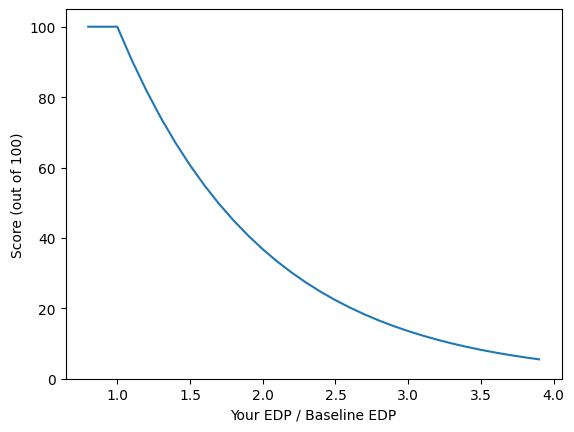

In [42]:
from math import exp

ratios = []
scores = []
for ratio in range(8, 40):
    ratio /= 10
    score = min(100, 100/exp(ratio-1))
    ratios.append(ratio)
    scores.append(score)

plt.plot(ratios, scores)
plt.ylim(0, 105)
plt.ylabel("Score (out of 100)")
plt.xlabel("Your EDP / Baseline EDP")

### Question 1: Specifying and Submitting a Memory Hierarchy

First, we will look at how to specify and submit a memory hierarchy.
The next question will give you more tools to aid your design process.

For now, note that a convenient architecture spec has been written for you, and all you need to do is specify a memory hierarchy following the example below.
The cell below records your final answer, and the code cell after it evaluates your answer and gives it a score.
At the end of your design space exploration, please put your final answer in the cell below.

You can run the following cells as many times as you want. For now, just run it to get familiar with the workflow.

In [43]:
# This is an example of two levels of memory hierarchy. From furthest to closest to the MAC: DRAM, L2, L1, and MAC.
# Capacity is in #tensor-elements and bandwidth is in #tensor-elements/cycle
final_memory_hierarchy = [
    {"name": "L2", "capacity": 1048576, "bandwidth": 8},
    {"name": "L1", "capacity": 1024, "bandwidth": 8},
]
########################
#### YOUR CODE HERE ####
########################

In [44]:
spec = af.Spec.from_yaml(
    "arch/scaffold.yaml",
    "workload/matmul.yaml",
    jinja_parse_data=dict(M=M, N=N, K=K, DRAM_BW=DRAM_BW, memory_hierarchy=final_memory_hierarchy)
)
spec.mapper.metrics = Metrics.LATENCY | Metrics.ENERGY
area = spec.calculate_component_area_energy_latency_leak().arch.total_area
mappings = spec.map_workload_to_arch()
mappings = mappings[min_edp_filter(mappings.data)]

print("Your area is", area)
answer(
    "3.1.1",
    "Is the memory hierarchy area within the allowed area?",
    answer=area <= ALLOWED_AREA,
    required_type=bool,
)
from math import exp

def score(edp):
    return min(100, 100/exp(edp/BASELINE_EDP - 1))

edp = (mappings.data["Total<SEP>energy"]*mappings.data["Total<SEP>latency"]).min()
print("Your EDP is", edp, "pJ*s")

answer(
    "3.1.2",
    "Your score is:",
    required_type=Number,
    answer=score(edp)
)

### END OF DO-NOT-MODIFY BLOCK ###

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 31it [00:00, 303.03it/s]

Generating pmapping templates for compute MAC Einsum matmul: 62it [00:00, 267.43it/s]

Generating pmapping templates for compute MAC Einsum matmul: 90it [00:00, 269.27it/s]

Generating pmapping templates for compute MAC Einsum matmul: 118it [00:00, 273.11it/s]

Generating pmapping templates for compute MAC Einsum matmul: 146it [00:00, 205.21it/s]

Generating pmapping templates for compute MAC Einsum matmul: 169it [00:00, 179.71it/s]

Generating pmapping templates for compute MAC Einsum matmul: 181it [00:00, 209.76it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

Einsum matmul has 181 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  MAC computes matmul
	1	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  MAC computes matmul
	2	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  MAC computes matmul
	3	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  MAC computes matmul
	4	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [B in L1] T-m  MAC computes matmul
	5	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [A in L1] T-n  MAC computes matmul
	6	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [Z in L1] T-k  MAC computes matmul
	7	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [A in L1] T-n  MAC computes matmul
	8	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [Z in L1] T-k  MAC computes matmul
	9	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [B in L1] T-m  MAC computes matmul
	10	[Z in DRAM] [B in DRAM] [A in DRAM

Generating pmappings:   0%|          | 0/181 [00:00<?, ?it/s]

Generating pmappings:   1%|          | 1/181 [00:01<05:58,  1.99s/it]

Generating pmappings:   1%|          | 2/181 [00:02<02:47,  1.07it/s]

Generating pmappings:   2%|▏         | 4/181 [00:02<01:07,  2.62it/s]

Generating pmappings:   3%|▎         | 6/181 [00:02<00:55,  3.15it/s]

Generating pmappings:   6%|▌         | 11/181 [00:02<00:22,  7.52it/s]

Generating pmappings:   8%|▊         | 14/181 [00:03<00:17,  9.34it/s]

Generating pmappings:   9%|▉         | 17/181 [00:03<00:15, 10.65it/s]

Generating pmappings:  12%|█▏        | 22/181 [00:03<00:12, 12.94it/s]

Generating pmappings:  15%|█▍        | 27/181 [00:03<00:08, 17.99it/s]

Generating pmappings:  17%|█▋        | 30/181 [00:03<00:09, 16.16it/s]

Generating pmappings:  19%|█▉        | 34/181 [00:04<00:07, 19.62it/s]

Generating pmappings:  20%|██        | 37/181 [00:04<00:07, 20.38it/s]

Generating pmappings:  22%|██▏       | 40/181 [00:04<00:08, 15.99it/s]

Generating pmappings:  25%|██▍       | 45/181 [00:04<00:10, 12.67it/s]

Generating pmappings:  33%|███▎      | 60/181 [00:05<00:04, 28.79it/s]

Generating pmappings:  36%|███▌      | 65/181 [00:05<00:04, 25.43it/s]

Generating pmappings:  38%|███▊      | 69/181 [00:05<00:04, 24.62it/s]

Generating pmappings:  41%|████      | 74/181 [00:05<00:04, 26.01it/s]

Generating pmappings:  45%|████▍     | 81/181 [00:05<00:03, 31.34it/s]

Generating pmappings:  48%|████▊     | 86/181 [00:05<00:02, 33.68it/s]

Generating pmappings:  50%|████▉     | 90/181 [00:06<00:02, 31.35it/s]

Generating pmappings:  52%|█████▏    | 94/181 [00:06<00:02, 32.83it/s]

Generating pmappings:  54%|█████▍    | 98/181 [00:06<00:02, 32.17it/s]

Generating pmappings:  56%|█████▋    | 102/181 [00:06<00:02, 31.63it/s]

Generating pmappings:  59%|█████▊    | 106/181 [00:06<00:02, 33.34it/s]

Generating pmappings:  62%|██████▏   | 112/181 [00:06<00:01, 39.71it/s]

Generating pmappings:  65%|██████▍   | 117/181 [00:06<00:01, 38.56it/s]

Generating pmappings:  67%|██████▋   | 122/181 [00:06<00:01, 41.10it/s]

Generating pmappings:  73%|███████▎  | 133/181 [00:07<00:00, 57.35it/s]

Generating pmappings:  77%|███████▋  | 139/181 [00:07<00:00, 51.17it/s]

Generating pmappings:  80%|████████  | 145/181 [00:07<00:00, 46.72it/s]

Generating pmappings:  84%|████████▍ | 152/181 [00:07<00:00, 52.07it/s]

Generating pmappings:  89%|████████▉ | 161/181 [00:07<00:00, 60.86it/s]

Generating pmappings:  99%|█████████▉| 180/181 [00:08<00:00, 38.30it/s]

Generating pmappings: 100%|██████████| 181/181 [00:08<00:00, 21.97it/s]

Grouping pmappings for matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

matmul: 3.37e06 total, 7.64e05 (1/4) valid, 6.68e05 (1/5) evaluated, 1 (1/3.37e06) Pareto-Optimal
Total: 3.37e06 total, 7.64e05 (1/4) valid, 6.68e05 (1/5) evaluated, 1 (1/3.37e06) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 174.25it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 5412.01it/s]

Your area is 1.65221086e-06
3.1.1: Is the memory hierarchy area within the allowed area?
	True
Your EDP is 7.22557062902605 pJ*s


3.1.2: Your score is:
	100


### Question 2: Some Tools for Your Design

None of the following cells are graded, but they are immensely useful to help your design process.

Please read the following code cell to understand how it works, and run it.

In [45]:
# Holds a dict mapping name of experiment (of your choosing) to the memory hierarchy
# An example is provided, and you can add more here to keep track of your designs.
EXPERIMENTS = {}
EXPERIMENTS["default"] = [
    {"name": "L2", "capacity": 4096, "bandwidth": 1},
    {"name": "L1", "capacity": 512, "bandwidth": 1},
]
EXPERIMENTS["optimal"] = [
    {"name": "L2", "capacity": 1048576, "bandwidth": 8},
    {"name": "L1", "capacity": 1024, "bandwidth": 8},
]

# Holds mappings that result from the mapping search for each experiment
MAPPINGS = {}
# Holds areas of the architecture using the memory hierarchy of each experiment
AREAS = {}

for experiment in EXPERIMENTS:
    memory_hierarchy = EXPERIMENTS[experiment]
    spec = af.Spec.from_yaml(
        "arch/scaffold.yaml",
        "workload/matmul.yaml",
        jinja_parse_data=dict(M=M, N=N, K=K, DRAM_BW=DRAM_BW, memory_hierarchy=memory_hierarchy)
    )
    spec.mapper.metrics = Metrics.LATENCY | Metrics.ENERGY
    area = spec.calculate_component_area_energy_latency_leak().arch.total_area
    mappings = spec.map_workload_to_arch()
    mappings = mappings[min_edp_filter(mappings.data)]
    MAPPINGS[experiment] = mappings
    AREAS[experiment] = area

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 21it [00:00, 199.62it/s]

Generating pmapping templates for compute MAC Einsum matmul: 41it [00:00, 187.10it/s]

Generating pmapping templates for compute MAC Einsum matmul: 60it [00:00, 179.12it/s]

Generating pmapping templates for compute MAC Einsum matmul: 78it [00:00, 166.84it/s]

Generating pmapping templates for compute MAC Einsum matmul: 96it [00:00, 170.15it/s]

Generating pmapping templates for compute MAC Einsum matmul: 114it [00:00, 162.06it/s]

Generating pmapping templates for compute MAC Einsum matmul: 131it [00:00, 164.35it/s]

Generating pmapping templates for compute MAC Einsum matmul: 148it [00:00, 161.43it/s]

Generating pmapping templates for compute MAC Einsum matmul: 165it [00:00, 159.02it/s]

Generating pmapping templates for compute MAC Einsum matmul: 181it [00:01, 166.09it/s]


Generating jobs: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Generating jobs: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Einsum matmul has 181 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  MAC computes matmul
	1	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  MAC computes matmul
	2	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  MAC computes matmul
	3	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  MAC computes matmul
	4	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [B in L1] T-m  MAC computes matmul
	5	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [A in L1] T-n  MAC computes matmul
	6	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [Z in L1] T-k  MAC computes matmul
	7	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [A in L1] T-n  MAC computes matmul
	8	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [Z in L1] T-k  MAC computes matmul
	9	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [B in L1] T-m  MAC computes matmul
	10	[Z in DRAM] [B in DRAM] [A in DRAM

Generating pmappings:   0%|          | 0/181 [00:00<?, ?it/s]

Generating pmappings:   1%|          | 1/181 [00:00<01:30,  1.99it/s]

Generating pmappings:   2%|▏         | 4/181 [00:00<00:23,  7.63it/s]

Generating pmappings:   3%|▎         | 6/181 [00:00<00:17, 10.13it/s]

Generating pmappings:   4%|▍         | 8/181 [00:00<00:14, 12.28it/s]

Generating pmappings:   7%|▋         | 12/181 [00:00<00:09, 18.37it/s]

Generating pmappings:   8%|▊         | 15/181 [00:01<00:08, 18.78it/s]

Generating pmappings:  10%|█         | 19/181 [00:01<00:06, 23.66it/s]

Generating pmappings:  12%|█▏        | 22/181 [00:01<00:07, 22.58it/s]

Generating pmappings:  14%|█▍        | 26/181 [00:01<00:05, 26.84it/s]

Generating pmappings:  16%|█▌        | 29/181 [00:01<00:05, 26.46it/s]

Generating pmappings:  18%|█▊        | 33/181 [00:01<00:04, 29.63it/s]

Generating pmappings:  20%|██        | 37/181 [00:01<00:05, 26.58it/s]

Generating pmappings:  23%|██▎       | 42/181 [00:01<00:04, 31.75it/s]

Generating pmappings:  25%|██▌       | 46/181 [00:02<00:05, 25.99it/s]

Generating pmappings:  27%|██▋       | 49/181 [00:02<00:05, 24.58it/s]

Generating pmappings:  29%|██▊       | 52/181 [00:02<00:08, 14.84it/s]

Generating pmappings:  36%|███▌      | 65/181 [00:02<00:03, 32.47it/s]

Generating pmappings:  39%|███▉      | 71/181 [00:03<00:03, 28.57it/s]

Generating pmappings:  42%|████▏     | 76/181 [00:03<00:03, 31.36it/s]

Generating pmappings:  46%|████▌     | 83/181 [00:03<00:02, 38.20it/s]

Generating pmappings:  49%|████▉     | 89/181 [00:03<00:02, 31.63it/s]

Generating pmappings:  52%|█████▏    | 94/181 [00:03<00:02, 31.48it/s]

Generating pmappings:  55%|█████▌    | 100/181 [00:03<00:02, 34.47it/s]

Generating pmappings:  59%|█████▉    | 107/181 [00:04<00:01, 41.02it/s]

Generating pmappings:  62%|██████▏   | 112/181 [00:04<00:01, 35.76it/s]

Generating pmappings:  68%|██████▊   | 123/181 [00:04<00:01, 45.82it/s]

Generating pmappings:  71%|███████▏  | 129/181 [00:04<00:01, 47.65it/s]

Generating pmappings:  75%|███████▍  | 135/181 [00:04<00:00, 46.85it/s]

Generating pmappings:  77%|███████▋  | 140/181 [00:04<00:00, 47.26it/s]

Generating pmappings:  81%|████████  | 147/181 [00:04<00:00, 46.36it/s]

Generating pmappings:  88%|████████▊ | 160/181 [00:05<00:00, 62.27it/s]

Generating pmappings:  98%|█████████▊| 178/181 [00:05<00:00, 89.25it/s]

Generating pmappings: 100%|██████████| 181/181 [00:05<00:00, 34.87it/s]

Grouping pmappings for matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]

matmul: 3.37e06 total, 1.43e05 (1/24) valid, 2.36e05 (1/14) evaluated, 6 (1/5.62e05) Pareto-Optimal
Total: 3.37e06 total, 1.43e05 (1/24) valid, 2.36e05 (1/14) evaluated, 6 (1/5.62e05) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 170.25it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 3151.24it/s]

Evaluating chosen mappings in detail:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:  17%|█▋        | 1/6 [00:00<00:00,  9.24it/s]

Evaluating chosen mappings in detail: 100%|██████████| 6/6 [00:00<00:00, 36.80it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running matmul: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum matmul: 30it [00:00, 289.11it/s]

Generating pmapping templates for compute MAC Einsum matmul: 59it [00:00, 280.56it/s]

Generating pmapping templates for compute MAC Einsum matmul: 88it [00:00, 275.15it/s]

Generating pmapping templates for compute MAC Einsum matmul: 116it [00:00, 211.63it/s]

Generating pmapping templates for compute MAC Einsum matmul: 139it [00:00, 199.52it/s]

Generating pmapping templates for compute MAC Einsum matmul: 160it [00:00, 178.44it/s]

Generating pmapping templates for compute MAC Einsum matmul: 179it [00:00, 175.20it/s]

Generating pmapping templates for compute MAC Einsum matmul: 181it [00:00, 199.85it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Einsum matmul has 181 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  MAC computes matmul
	1	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  MAC computes matmul
	2	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  MAC computes matmul
	3	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  MAC computes matmul
	4	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [B in L1] T-m  MAC computes matmul
	5	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [A in L1] T-n  MAC computes matmul
	6	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  [A in L1] T-n  [Z in L1] T-k  MAC computes matmul
	7	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [A in L1] T-n  MAC computes matmul
	8	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-n  [B in L1] T-m  [Z in L1] T-k  MAC computes matmul
	9	[Z in DRAM] [B in DRAM] [A in DRAM] T-m  T-n  [Z in L1] T-k  [B in L1] T-m  MAC computes matmul
	10	[Z in DRAM] [B in DRAM] [A in DRAM

Generating pmappings:   0%|          | 0/181 [00:00<?, ?it/s]

Generating pmappings:   1%|          | 1/181 [00:00<01:31,  1.98it/s]

Generating pmappings:   1%|          | 2/181 [00:00<00:48,  3.66it/s]

Generating pmappings:   3%|▎         | 5/181 [00:00<00:18,  9.61it/s]

Generating pmappings:   4%|▍         | 7/181 [00:00<00:19,  9.16it/s]

Generating pmappings:   5%|▍         | 9/181 [00:01<00:16, 10.33it/s]

Generating pmappings:   8%|▊         | 15/181 [00:01<00:08, 20.36it/s]

Generating pmappings:  10%|▉         | 18/181 [00:01<00:10, 16.12it/s]

Generating pmappings:  13%|█▎        | 23/181 [00:01<00:07, 22.38it/s]

Generating pmappings:  15%|█▍        | 27/181 [00:01<00:06, 24.95it/s]

Generating pmappings:  17%|█▋        | 31/181 [00:02<00:07, 20.19it/s]

Generating pmappings:  19%|█▉        | 35/181 [00:02<00:06, 23.65it/s]

Generating pmappings:  22%|██▏       | 39/181 [00:02<00:05, 24.82it/s]

Generating pmappings:  23%|██▎       | 42/181 [00:02<00:05, 23.98it/s]

Generating pmappings:  27%|██▋       | 48/181 [00:02<00:04, 29.56it/s]

Generating pmappings:  29%|██▊       | 52/181 [00:02<00:04, 27.37it/s]

Generating pmappings:  30%|███       | 55/181 [00:02<00:05, 22.22it/s]

Generating pmappings:  32%|███▏      | 58/181 [00:03<00:05, 22.07it/s]

Generating pmappings:  35%|███▌      | 64/181 [00:03<00:04, 24.78it/s]

Generating pmappings:  37%|███▋      | 67/181 [00:03<00:04, 25.11it/s]

Generating pmappings:  40%|███▉      | 72/181 [00:03<00:03, 29.07it/s]

Generating pmappings:  42%|████▏     | 76/181 [00:03<00:03, 27.99it/s]

Generating pmappings:  45%|████▍     | 81/181 [00:03<00:03, 32.35it/s]

Generating pmappings:  48%|████▊     | 86/181 [00:03<00:02, 35.71it/s]

Generating pmappings:  50%|████▉     | 90/181 [00:04<00:05, 16.76it/s]

Generating pmappings:  56%|█████▋    | 102/181 [00:04<00:02, 31.03it/s]

Generating pmappings:  60%|██████    | 109/181 [00:04<00:02, 35.33it/s]

Generating pmappings:  64%|██████▎   | 115/181 [00:04<00:01, 36.50it/s]

Generating pmappings:  70%|██████▉   | 126/181 [00:05<00:01, 45.12it/s]

Generating pmappings:  74%|███████▍  | 134/181 [00:05<00:00, 49.12it/s]

Generating pmappings:  78%|███████▊  | 141/181 [00:05<00:00, 47.32it/s]

Generating pmappings:  81%|████████  | 147/181 [00:05<00:00, 46.49it/s]

Generating pmappings:  90%|████████▉ | 162/181 [00:05<00:00, 67.60it/s]

Generating pmappings:  99%|█████████▉| 180/181 [00:05<00:00, 85.81it/s]

Generating pmappings: 100%|██████████| 181/181 [00:05<00:00, 30.92it/s]

Grouping pmappings for matmul:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for matmul: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

matmul: 3.37e06 total, 7.56e05 (1/4) valid, 6.68e05 (1/5) evaluated, 1 (1/3.37e06) Pareto-Optimal
Total: 3.37e06 total, 7.56e05 (1/4) valid, 6.68e05 (1/5) evaluated, 1 (1/3.37e06) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 160.65it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 2639.59it/s]

The following cell plots a comparison of total energy for all experiments and all mappings.
The x-axis labels follows the format "ExperimentName-mx" where each mx is a mapping.
You should only ever see m0 in this exploration, but in general the mapper may return an entire trade-off curve (m0 means is the first mapping in the curve, m1 is the second mapping, and so on).

(<Figure size 200x400 with 1 Axes>, <Axes: ylabel='Energy (pJ)'>)

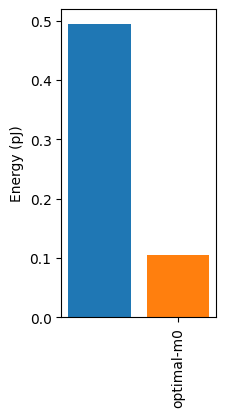

In [46]:
plot_energy_comparison(list(MAPPINGS.values()), labels=list(MAPPINGS.keys()))

The following cell plots the energy breakdown by component (see AccelForge API docs for more options) for all experiments.

/home/fisherxue/65931S2026/accelforge/accelforge/plotting/mappings.py:165: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 600x400 with 2 Axes>,
 array([<Axes: title={'center': 'default-m0'}, ylabel='Energy (pJ)'>,
        <Axes: title={'center': 'optimal-m0'}>], dtype=object))

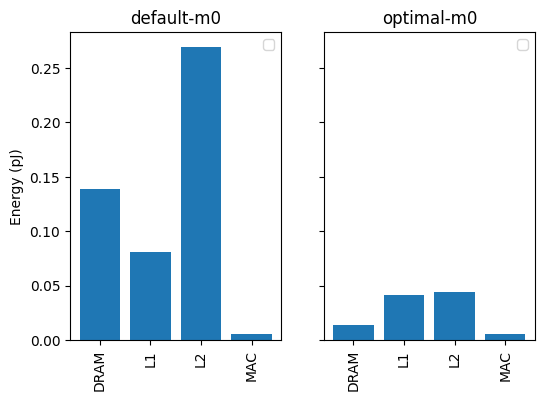

In [47]:
plot_energy_breakdown(list(MAPPINGS.values()), separate_by=["component"], labels=list(MAPPINGS.keys()))

The following cell compares the areas of each experiment.

<BarContainer object of 2 artists>

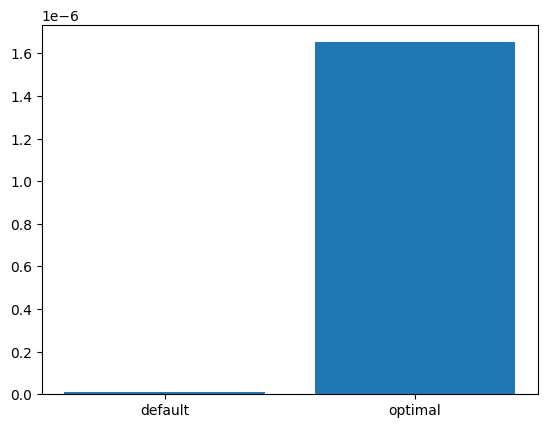

In [48]:
plt.bar(AREAS.keys(), AREAS.values())

That is it! Now, you should be well equipped to explore the design space.

## Section 4: Layout Assumptions to Consider

As Box said, "[all models are wrong, but some are useful](https://en.wikipedia.org/wiki/All_models_are_wrong)."
In this part, we will explore an aspect that our modeling has not accounted for: data layout in memory.

In memory (circuit) implementations, bits are arranged in an array.
When data is needed, an entire row of bits can be accessed at the same time and delivered to a read port.
Because of this fact, how a tensor is laid out in the memory array (*i.e.*, the data *layout*) can affect the number of accesses necessary to read a set of tensor elements.

### Question 1: Understanding and Specifying Layout

Suppose we use a DRAM array, which holds 64 bits within a row, to store tensor $A$, which uses 8 bits per tensor element. 

Please answer the following question.

In [49]:
DRAM_WIDTH_IN_BITS = 64
BITS_PER_TENSOR_ELEMENT = 8

# Place your answer as the value of DRAM_WIDTH.
# You can use this variable in later questions
DRAM_WIDTH = DRAM_WIDTH_IN_BITS // BITS_PER_TENSOR_ELEMENT   # SRAM width in number of tensor elements
########################
#### YOUR CODE HERE ####
########################
answer(
    "4.1.1",
    "How many tensor elements can the SRAM array hold within each row?",
    answer=DRAM_WIDTH,
    required_type=int,
)

4.1.1: How many tensor elements can the SRAM array hold within each row?
	8


So we can discuss layout, we give each 8 bit space in the DRAM array with a number as follows (*i.e.*, we give the DRAM memory address):

```
0,   1,   2, ..., N-1 (where N is your answer to 4.1.1)
N, N+1, N+2, ..., 2*N-1,
...
```

Thus, the layout is a mapping between tensor coordinates to address. For the rest of the lab, we will focus on tensor $A$ in the matrix multiplication from the beginning of the lab.

Please run the following cell and inspect the output.

In [50]:
# Rank shapes are as follows (DO NOT MODIFY):
M = 32
N = 32
K = 16

# Starting tensors
A = Tensor("A", shape=(M, K))
B = Tensor("B", shape=(K, N))
Z = Tensor("Z", shape=(M, N), is_output=True)


def print_first_couple_rows(layout_func, nrows=4):
    W = 8
    first_couple_rows = [[None]*W for _ in range(nrows)]
    max_char_len = 0
    for m in range(M):
        for k in range(K):
            addr = layout_func(m, k)
            row = addr // W
            col = addr % W
            if row < nrows:
                element = f"A[{m},{k}]"
                max_char_len = max(max_char_len, len(element))
                first_couple_rows[row][col] = element

    # Align whitespace
    first_couple_rows = [
        [elem + " "*(max_char_len-len(elem)) for elem in row]
        for row in first_couple_rows
    ]

    for row in first_couple_rows:
        print(", ".join(row))


def layout_M_major(m: int, k: int) -> int:
    """
    Layout for tensor A that arranges elements within a single M coordinate
    within an SRAM row as much as possible.

    Parameters
    ----------
    m:
        coordinate along the M rank
    K:
        coordinate along the K rank

    Returns
    -------
    the address in SRAM of the tensor element A_{m,k}
    """
    return K*m + k


print_first_couple_rows(layout_M_major)

A[0,0] , A[0,1] , A[0,2] , A[0,3] , A[0,4] , A[0,5] , A[0,6] , A[0,7] 
A[0,8] , A[0,9] , A[0,10], A[0,11], A[0,12], A[0,13], A[0,14], A[0,15]
A[1,0] , A[1,1] , A[1,2] , A[1,3] , A[1,4] , A[1,5] , A[1,6] , A[1,7] 
A[1,8] , A[1,9] , A[1,10], A[1,11], A[1,12], A[1,13], A[1,14], A[1,15]


Now, please answer the following question.

In [51]:
def layout_K_major(m: int, k: int) -> int:
    return k * M + m
########################
#### YOUR CODE HERE ####
########################

print_first_couple_rows(layout_K_major, nrows=6)

# Hint: the first two rows and columns should look as follows:
#   A[0, 0], A[1, 0], ...
#   A[8, 0], A[9, 0], ...
#   ...
# The following code checks for this hint.
assert layout_K_major(0, 0) == 0, "A[0, 0] is in the wrong address"
assert layout_K_major(1, 0) == 1, "A[1, 0] is in the wrong address"
assert layout_K_major(8, 0) == 8, "A[8, 0] is in the wrong address"
assert layout_K_major(9, 0) == 9, "A[9, 0] is in the wrong address"
print("Your answer passes the hint check!")

answer(
    "4.1.2",
    "Your layout_K_major:",
    answer=layout_K_major,
    required_type=callable,
)

A[0,0] , A[1,0] , A[2,0] , A[3,0] , A[4,0] , A[5,0] , A[6,0] , A[7,0] 
A[8,0] , A[9,0] , A[10,0], A[11,0], A[12,0], A[13,0], A[14,0], A[15,0]
A[16,0], A[17,0], A[18,0], A[19,0], A[20,0], A[21,0], A[22,0], A[23,0]
A[24,0], A[25,0], A[26,0], A[27,0], A[28,0], A[29,0], A[30,0], A[31,0]
A[0,1] , A[1,1] , A[2,1] , A[3,1] , A[4,1] , A[5,1] , A[6,1] , A[7,1] 
A[8,1] , A[9,1] , A[10,1], A[11,1], A[12,1], A[13,1], A[14,1], A[15,1]
Your answer passes the hint check!
4.1.2: Your layout_K_major:
	{'callable': 'layout_K_major', 'source': 'def layout_K_major(m: int, k: int) -> int:\n    return k * M + m'}


### Question 2: The Latency Impact of Layout

For any set of tensor accesses to/from a memory, the total latency of these accesses depend on the mapping, which determines the order of accesses, and the tensor layout in memory.

For example, try writing down the access pattern of $A$ in DRAM in the following mapping.

In [52]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m in range(M):
        for n in range(N):
            for k in range(K):
                with GLB.allocate(A_in_DRAM[m, k]) as A_in_GLB:
                    Z_in_DRAM[m,n] += A_in_GLB[0,0] * B_in_DRAM[k,n]

Please answer the following questions.

In [53]:
answer(
    "4.2.1",
    """
    Assuming in each cycle, a row can be accessed from DRAM, how many cycles is
    necessary for each GLB access of A from DRAM assuming layout_M_major?
    """,
    answer= 1,
    required_type=Number,
)

answer(
    "4.2.2",
    """
    How many elements of A are accessed per cycle from the DRAM assuming layout_M_major?
    """,
    answer= 1,
    required_type=Number,
)

answer(
    "4.2.3",
    """
    How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_K_major?
    """,
    answer= 1,
    required_type=Number,
)

answer(
    "4.2.4",
    """
    How many elements of A are accessed per cycle from the DRAM assuming
    layout_K_major?
    """,
    answer= 1,
    required_type=Number,
)

4.2.1: 
    Assuming in each cycle, a row can be accessed from DRAM, how many cycles is
    necessary for each GLB access of A from DRAM assuming layout_M_major?
    
	1
4.2.2: 
    How many elements of A are accessed per cycle from the DRAM assuming layout_M_major?
    
	1
4.2.3: 
    How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_K_major?
    
	1
4.2.4: 
    How many elements of A are accessed per cycle from the DRAM assuming
    layout_K_major?
    
	1


Now for a different mapping:

In [54]:
# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m in range(M):
        for n in range(N):
            with GLB.allocate(A_in_DRAM[m, k]) as A_in_GLB:
                for k in range(K):
                    Z_in_DRAM[m,n] += A_in_GLB[0,0] * B_in_DRAM[k,n]

Please answer the following questions.

In [55]:
answer(
    "4.2.5",
    """
    How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_M_major?
    """,
    answer= 2,
    required_type=Number,
)

answer(
    "4.2.6",
    """How many elements of A are accessed per cycle from the DRAM assuming
    layout_M_major?
    """,
    answer= 8,
    required_type=Number,
)

answer(
    "4.2.7",
    """How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_K_major?
    """,
    answer= 16,
    required_type=Number,
)

answer(
    "4.2.8",
    """How many elements of A are accessed per cycle from the DRAM assuming
    layout_K_major?
    """,
    answer= 1,
    required_type=Number,
)

4.2.5: 
    How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_M_major?
    
	2
4.2.6: How many elements of A are accessed per cycle from the DRAM assuming
    layout_M_major?
    
	8
4.2.7: How many cycles is necessary for each GLB access of A from DRAM assuming
    layout_K_major?
    
	16
4.2.8: How many elements of A are accessed per cycle from the DRAM assuming
    layout_K_major?
    
	1


### Question 3: Optimizing Layout for a Mapping

As we can see, the latency of a mapping depends on the layout, and vice versa.

In this question, we will optimize data layout for a tiled mapping.

Please inspect the mapping in the cell below, and implement a layout that achieves the maximum possible number of tensor elements read per cycle.
The cell will also visualize your layout and print an estimate of the number of cycles to fetch the first tile (the estimate is an upper bound),
which you can use to determine how close your layout is to maximum bandwidth utilization.

In [56]:
# Rank shapes are as follows (DO NOT MODIFY, same as in previous question, copied here for convenience):
M = 32
N = 32
K = 16

A = Tensor("A", shape=(M, K))
B = Tensor("B", shape=(K, N))
Z = Tensor("Z", shape=(M, N), is_output=True)

# Create memory levels
DRAM = MemoryLevel("DRAM")
GLB = MemoryLevel("GLB")

M1 = 8
M0 = M // M1
N1 = 4
N0 = N // N1
K1 = 4
K0 = K // K1

with DRAM.allocate(A) as A_in_DRAM, \
     DRAM.allocate(B) as B_in_DRAM, \
     DRAM.allocate(Z) as Z_in_DRAM:
    for m1 in range(M1):
        for n1 in range(N1):
            for k1 in range(K1):
                with GLB.allocate(A_in_DRAM[M0*m1:M0*(m1+1), K0*k1:K0*(k1+1)]) as A_in_GLB:
                    for m0 in range(M0):
                        for n0 in range(N0):
                            for k0 in range(K0):
                                m = m1*M0 + m0
                                k = k1*K0 + k0
                                n = n1*N0 + n0
                                Z_in_DRAM[m,n] += A_in_GLB[m0,k0] * B_in_DRAM[k,n]

# Implement your optimized layout below!
def your_optimized_layout(m: int, k: int) -> int:
    # Blocked/tiled layout: elements within the same tile are stored contiguously
    # Tile indices
    m1 = m // M0
    k1 = k // K0
    # Offset within the tile
    m0 = m % M0
    k0 = k % K0
    # Tile ID (ordering tiles by m1 outer, k1 inner)
    tile_id = m1 * K1 + k1
    # Offset within tile (m0 outer, k0 inner for row-like access within tile)
    offset_in_tile = m0 * K0 + k0
    # Final address
    return tile_id * (M0 * K0) + offset_in_tile

print("First couple of rows (to help visualize your design, not part of question):")
print_first_couple_rows(your_optimized_layout)

print()
min_addr = float("inf")
max_addr = 0
for m0 in range(M0):
    for k0 in range(K0):
        min_addr = min(min_addr, your_optimized_layout(m0, k0))
        max_addr = max(max_addr, your_optimized_layout(m0, k0))
from math import ceil
print("Estimated (upper bound) number of cycles to fetch a tile:", ceil((max_addr-min_addr+1)/DRAM_WIDTH))

answer(
    "4.3.1",
    "Your optimized layout:",
    answer= your_optimized_layout,
    required_type=callable,
)

First couple of rows (to help visualize your design, not part of question):
A[0,0], A[0,1], A[0,2], A[0,3], A[1,0], A[1,1], A[1,2], A[1,3]
A[2,0], A[2,1], A[2,2], A[2,3], A[3,0], A[3,1], A[3,2], A[3,3]
A[0,4], A[0,5], A[0,6], A[0,7], A[1,4], A[1,5], A[1,6], A[1,7]
A[2,4], A[2,5], A[2,6], A[2,7], A[3,4], A[3,5], A[3,6], A[3,7]

Estimated (upper bound) number of cycles to fetch a tile: 2
4.3.1: Your optimized layout:
	{'callable': 'your_optimized_layout', 'source': 'def your_optimized_layout(m: int, k: int) -> int:\n    # Blocked/tiled layout: elements within the same tile are stored contiguously\n    # Tile indices\n    m1 = m // M0\n    k1 = k // K0\n    # Offset within the tile\n    m0 = m % M0\n    k0 = k % K0\n    # Tile ID (ordering tiles by m1 outer, k1 inner)\n    tile_id = m1 * K1 + k1\n    # Offset within tile (m0 outer, k0 inner for row-like access within tile)\n    offset_in_tile = m0 * K0 + k0\n    # Final address\n    return tile_id * (M0 * K0) + offset_in_tile'}


## Concluding Lab 2

You have completed Lab 2! Please follow the instructions in the README to submit your answers.